In [14]:
import numpy as np
import gensim
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle

In [15]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
print('Number of words in corpora: %d'%(len(corpora)))

Number of words in corpora: 26


In [16]:
tmp = list(corpora.items())

In [17]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [18]:
seq_length = 2

In [19]:
dataX = []
dataY = []
for i in range(0, len(text)-seq_length, 1):
    seq_in = text[i:i+seq_length]
    seq_out = text[i+seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)
    #tmp_seq_in = [corpora.id2token[value] for value in seq_in]
    #print(tmp_seq_in)
    #print(corpora.id2token[seq_out])

In [20]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (len(dataX), seq_length, 1))
# normalize
X = X / float(len(corpora))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [21]:
print( 'dataY len: %d min: %d max: %d'%(len(dataY), np.min(dataY), np.max(dataY)))

dataY len: 28 min: 1 max: 25


In [22]:
y.shape

(28, 26)

### Create and fit the model

In [23]:
def create_model(fweights=None):
    batch_size = 1
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], 1)))
    model.add(Dense(y.shape[1], activation='softmax'))
    if fweights is not None:
        model.load_weights(fweights)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
model = create_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_2 (LSTM)                    (None, 50)            10400       lstm_input_2[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 26)            1326        lstm_2[0][0]                     
Total params: 11726
____________________________________________________________________________________________________


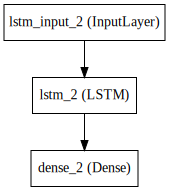

In [25]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the model

In [26]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, nb_epoch=500, batch_size=1, verbose=2, callbacks=[checkpoint])
# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/500
Epoch 00000: acc improved from -inf to 0.00000, saving model to weights.best.hdf5
0s - loss: 3.2738 - acc: 0.0000e+00
Epoch 2/500
Epoch 00001: acc improved from 0.00000 to 0.07143, saving model to weights.best.hdf5
0s - loss: 3.2483 - acc: 0.0714
Epoch 3/500
Epoch 00002: acc did not improve
0s - loss: 3.2334 - acc: 0.0000e+00
Epoch 4/500
Epoch 00003: acc did not improve
0s - loss: 3.2159 - acc: 0.0357
Epoch 5/500
Epoch 00004: acc did not improve
0s - loss: 3.2025 - acc: 0.0357
Epoch 6/500
Epoch 00005: acc did not improve
0s - loss: 3.1813 - acc: 0.0714
Epoch 7/500
Epoch 00006: acc did not improve
0s - loss: 3.1649 - acc: 0.0357
Epoch 8/500
Epoch 00007: acc did not improve
0s - loss: 3.1421 - acc: 0.0000e+00
Epoch 9/500
Epoch 00008: acc did not improve
0s - loss: 3.1211 - acc: 0.0714
Epoch 10/500
Epoch 00009: acc did not improve
0s - loss: 3.1052 - acc: 0.0357
Epoch 11/500
Epoch 00010: acc did not improve
0s - loss: 3.0830 - acc: 0.0714
Epoch 12/500
Epoch 00011: acc did not 

In [27]:
model.save('./models/dev_jason_statefull_LSTM.h5')

### Demonstrate some model predictions

In [28]:
# load weights
model = create_model("weights.best.hdf5")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_3 (LSTM)                    (None, 50)            10400       lstm_input_3[0][0]               
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 26)            1326        lstm_3[0][0]                     
Total params: 11726
____________________________________________________________________________________________________


In [29]:
max_len = 2

for i in range(20):
    pattern_index = np.random.randint(len(dataX))
    pattern = dataX[pattern_index]
    x = pad_sequences([pattern], maxlen=max_len, dtype='float32')
    x = np.reshape(x, (1, max_len, 1))
    x = x / float(len(corpora))
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    #result = int_to_char[index]
    #seq_in = [int_to_char[value] for value in pattern]
    result = corpora.id2token[index]
    seq_in = [corpora.id2token[value] for value in pattern]
    print(seq_in, "->", result)

['The', 'quick'] -> brown
['seven', 'eight'] -> nine
['two', 'three'] -> four
['six', 'seven'] -> eight
['jumps', 'over'] -> a
['brown', 'fox'] -> jumps
['you', '?'] -> you
['four', 'five'] -> six
['you', 'doing'] -> ?
['fox', 'jumps'] -> over
['two', 'three'] -> four
['fox', 'jumps'] -> over
['dog', '.'] -> How
['jumps', 'over'] -> a
['seven', 'eight'] -> nine
['nine', 'ten'] -> .
['What', 'are'] -> you
['brown', 'fox'] -> jumps
['are', 'you'] -> ?
['?', 'What'] -> are
